In [1]:
import os
os.chdir('/Users/abhishek/Documents/Personal/merchant-categorization')

In [2]:
import json
import time
from datetime import datetime, timedelta

import regex as re
import pandas as pd
import numpy as np

In [3]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [4]:
import src.preprocessing as prep
import src.categorization as cluster
import configs as CFG

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [5]:
data = pd.read_csv(CFG.SAMPLE_INPUT_DATA)
print(f'Number of rows in data: {len(data)}')

Number of rows in data: 450601


In [6]:
CURRENT_TIME = datetime.now().strftime('%Y-%m-%d_%H-%M')
TEXT_COL = 'pos'

In [7]:
data = data[
    (data[TEXT_COL].notna()) &      ## remove null values
    (data[TEXT_COL] != '-1') &      ## remove -1 values
    (data[TEXT_COL] != '')          ## remove empty strings
]
print(f'Number of rows after removing unnecessary rows: {len(data)}')

## Clean text
print('Cleaning text...')
data[f'cleaned_{TEXT_COL}'] = data[TEXT_COL].parallel_apply(prep.wordify)


Number of rows after removing unnecessary rows: 450441
Cleaning text...


In [8]:
data.head()

,templatehash,servicename,pos,transactionnote,dt,cleaned_pos
0,87ef3be73ec13ce91ddd7ea26f1cf018,BANK OF BARODA,entercloud trad,axisp00584578002,2024-12-19,entercloud trad
1,87ef3be73ec13ce91ddd7ea26f1cf018,BANK OF BARODA,sharad building,sbin424268953866,2024-12-19,sharad building
2,87ef3be73ec13ce91ddd7ea26f1cf018,BANK OF BARODA,ENDURAFAB PRIVA,AXISP00490199782,2024-12-19,endurafab priva
3,87ef3be73ec13ce91ddd7ea26f1cf018,BANK OF BARODA,ENTERPRISE,P239240346760939,2024-12-19,enterprise
4,87ef3be73ec13ce91ddd7ea26f1cf018,BANK OF BARODA,shagolsem chara,ioban24321071750,2024-12-19,shagolsem chara


In [9]:
data.loc[data['cleaned_pos'].apply(lambda x: len(x) if x else 0) > 16, ['pos', 'cleaned_pos']].sample(n=20)

,pos,cleaned_pos
61501,AU SMALL FINANCE BANK LIMITED,au small finance bank limited
335562,Venkataramana Oil Fill,venkataramana oil fill
24359,CHRISTIAN MEDICAL COL,christian medical col
312380,"Bharti Airtel Limited, Delhi",bharti airtel limited delhi
374081,TOPDOM MARKETING PVT LTD,topdom marketing pvt ltd
11990,RATHNA FASHIONS SBIN,rathna fashions sbin
101897,MSWMAHESH MEDICAL AND Mumbai IND,mswmahesh medical and mumbai ind
39316,Foodpanda Philippines,foodpanda philippines
132811,MAHINDRA AND MAHINDRA 944HDFC0,mahindra and mahindra hdfc
55033,HERO FINCORP LIMITED,hero fincorp limited


In [10]:
text_column = 'cleaned_pos'

In [12]:
df = data[data['cleaned_pos'] != '']
df.shape

(450441, 6)

In [13]:
df = df.drop_duplicates('cleaned_pos')
df.shape

(76264, 6)

In [14]:
df['cleaned_pos'].astype(str).parallel_apply(len).describe(percentiles=[i/20 for i in range(21)])

count    76264.000000
mean        18.747115
std          9.000488
min          2.000000
0%           2.000000
5%           7.000000
10%          9.000000
15%         10.000000
20%         11.000000
25%         13.000000
30%         14.000000
35%         15.000000
40%         16.000000
45%         17.000000
50%         18.000000
55%         19.000000
60%         20.000000
65%         21.000000
70%         22.000000
75%         23.000000
80%         25.000000
85%         27.000000
90%         30.000000
95%         34.000000
100%       100.000000
max        100.000000
Name: cleaned_pos, dtype: float64

In [15]:
df = df[df['cleaned_pos'].astype(str).apply(len) >= 8]
df.shape

(71166, 6)

In [16]:
# Prepare the data for FastText
# FastText expects one sentence per line, with labels prefixed by __label__
# with open('fasttext_input.txt', 'w', encoding='utf-8') as f:
#     for text in df[text_column]:
#         f.write(f'__label__dummy {text}\n')

In [17]:
import fasttext

# Train the FastText model
# model = fasttext.train_unsupervised('fasttext_input.txt', model='skipgram')

In [18]:
# # Save the model
# model.save_model("model.bin")

In [20]:
# Load the model
model = fasttext.load_model("files/model.bin")

# Get all words and their vectors
# words = model.get_words()
# with open("model.vec", 'w') as file_out:
#     # Write header: number of words and vector dimension
#     file_out.write(f"{len(words)} {model.get_dimension()}\n")
#     print(f"{len(words)} {model.get_dimension()}")
    
#     # Write word vectors
#     for word in words:
#         vector = model.get_word_vector(word)
#         vector_str = ' '.join([f"{v:.4f}" for v in vector])
#         try:
#             file_out.write(f"{word} {vector_str}\n")
#         except:
#             pass


In [21]:
# Function to get embeddings for a text
def get_embedding(text):
    return model.get_sentence_vector(text)

In [22]:
# Apply the function to create embeddings
df['embeddings'] = df[text_column].parallel_apply(get_embedding)

In [23]:
df['embeddings'].shape

(71166,)

In [24]:
df['embeddings'].iloc[0].shape

(100,)

In [25]:
from hdbscan import HDBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import umap  # Optional: for dimensionality reduction before clustering
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from itertools import product

In [26]:
embeddings = np.vstack(df['embeddings'].tolist())

In [27]:
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(embeddings)

scaled_embeddings.shape

(71166, 100)

In [28]:
from importlib import reload as r

Running PCA...
Number of components: 50


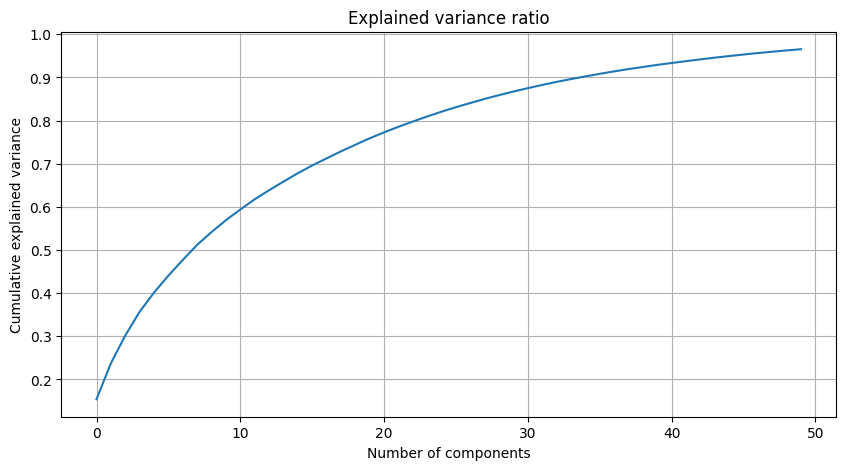

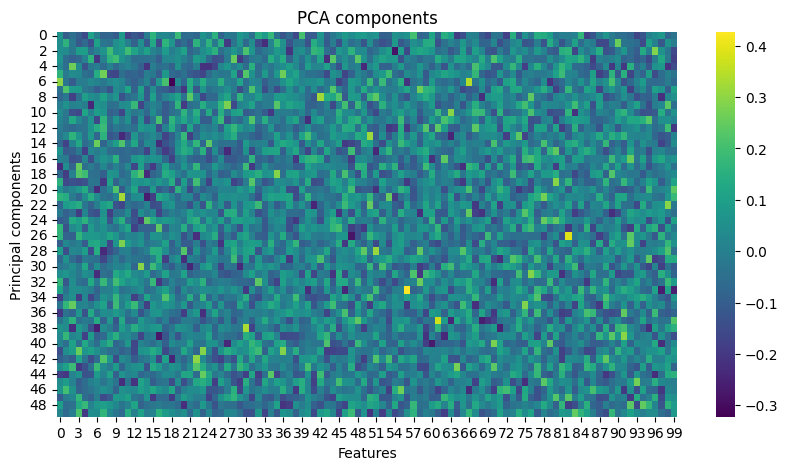

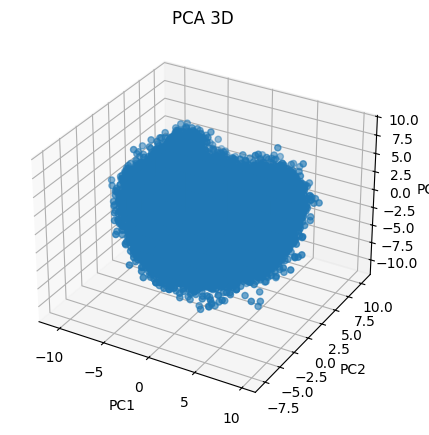

In [42]:
r(cluster)
pca_embeddings = cluster.run_pca(
    scaled_embeddings=scaled_embeddings,
    n_components=50,
    visualize=True
)

Text(0.5, 0.92, 'PCA 3D')

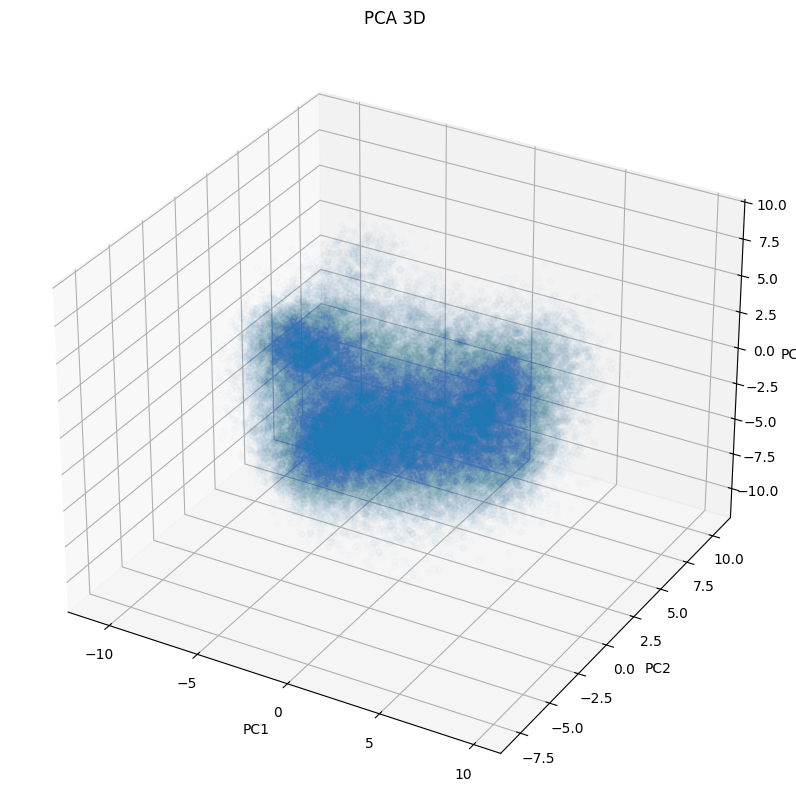

In [37]:
## Visualize pca embeddings in 3d
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_embeddings[:, 0], pca_embeddings[:, 1], pca_embeddings[:, 2], alpha=0.01)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('PCA 3D')


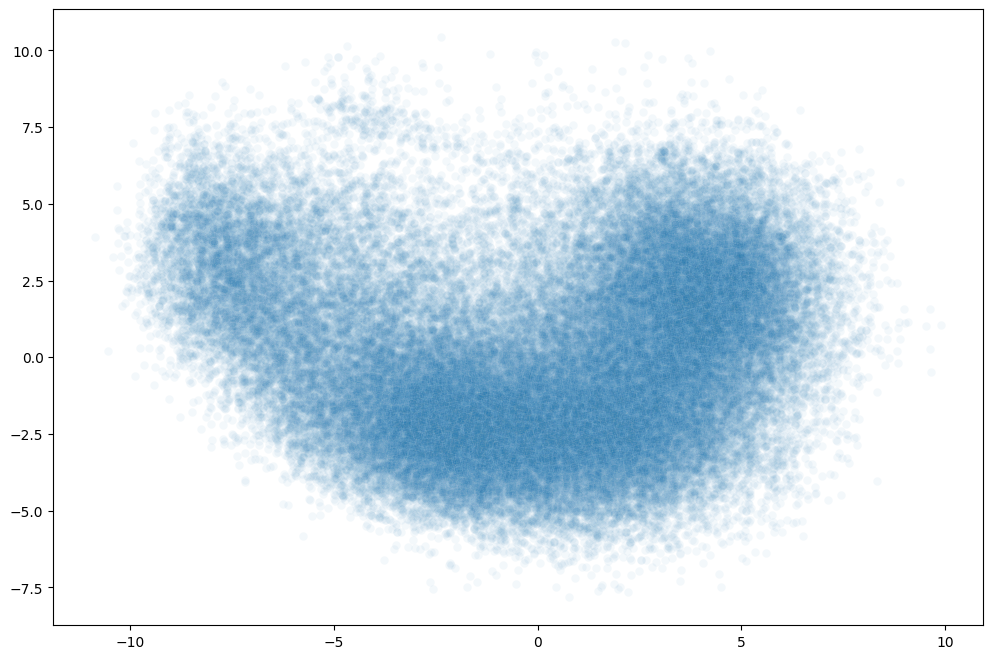

In [41]:
from scipy.cluster.vq import kmeans
fig = plt.figure(figsize=(12, 8))
ax = sns.scatterplot(x=pca_embeddings[:, 0], y=pca_embeddings[:, 1], alpha=0.05)

Running UMAP with n_components=40, n_neighbors=15, min_dist=None, metric=cosine


/Users/abhishek/micromamba/envs/venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


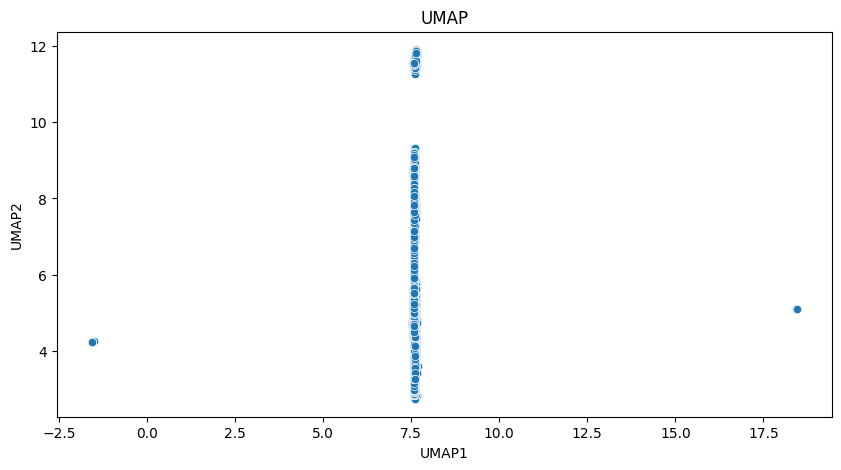

In [ ]:
r(cluster)
umap_embeddings = cluster.run_umap(
    scaled_embeddings=embeddings,
    n_components=40,
    visualize=True
)

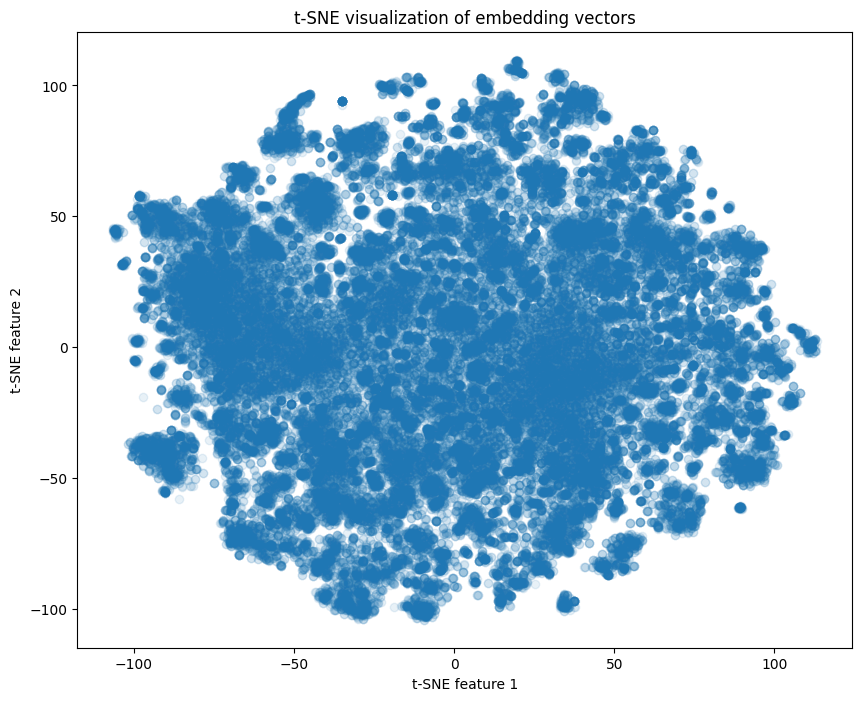

In [ ]:
from sklearn.manifold import TSNE

# Assuming you have your embedding vectors stored in a numpy array called 'embeddings'
# embeddings shape: (n_samples, n_features)

# Create a t-SNE model
tsne = TSNE(n_components=2, random_state=42)

# Fit and transform the embeddings
tsne_results = tsne.fit_transform(embeddings)

# Plot the results
plt.figure(figsize=(10, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.1)
plt.title('t-SNE visualization of embedding vectors')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()


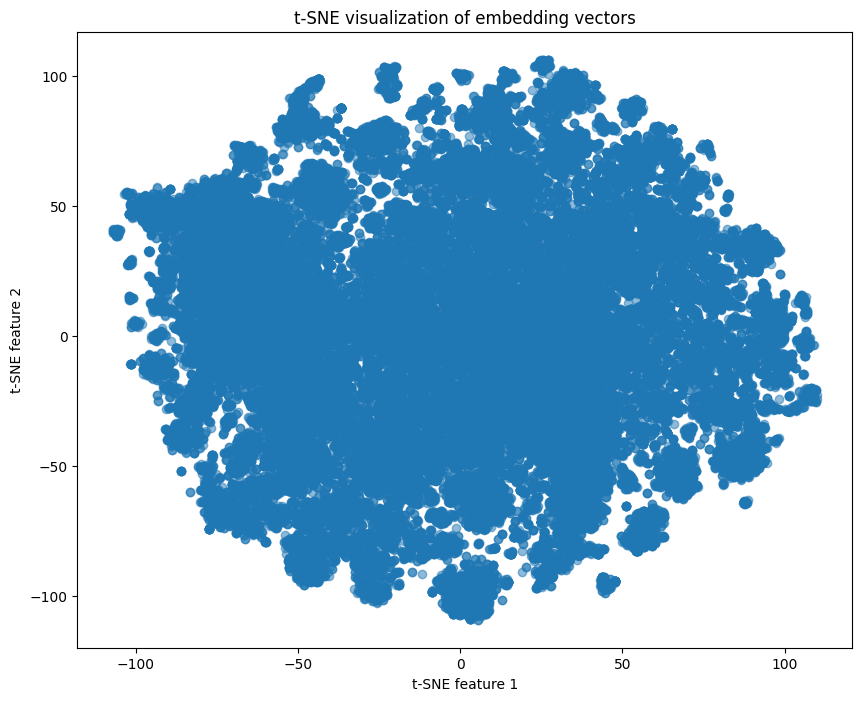

In [48]:
tsne = TSNE(n_components=2, random_state=42)

# Fit and transform the embeddings
tsne_results_scaled = tsne.fit_transform(scaled_embeddings)

# Plot the results
plt.figure(figsize=(10, 8))
plt.scatter(tsne_results_scaled[:, 0], tsne_results_scaled[:, 1], alpha=0.5)
plt.title('t-SNE visualization of embedding vectors')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()


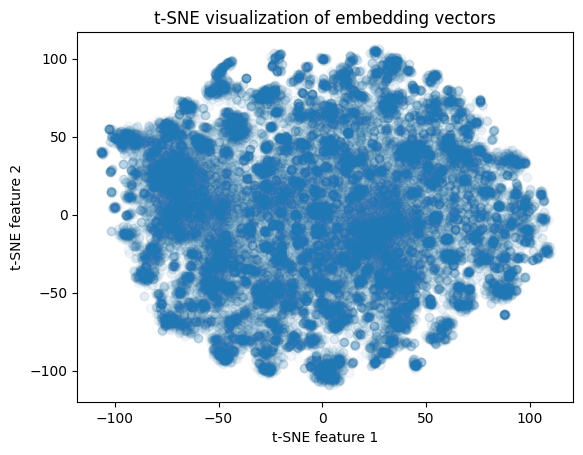

In [52]:
plt.scatter(tsne_results_scaled[:, 0], tsne_results_scaled[:, 1], alpha=0.025)
plt.title('t-SNE visualization of embedding vectors')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()


In [80]:
## eclidean distance between vector embeddings

def euc_dist(a,b):
    return np.linalg.norm(a-b)

euc_dist(scaled_embeddings[0],scaled_embeddings[1])

np.float32(15.648525)

In [81]:
from tqdm import tqdm

In [89]:
# import numpy as np
# distances = []
# total_len = len(scaled_embeddings)
# for x in tqdm(range(total_len)):
#     for y in range(x+1, total_len):
#         distances.append(np.linalg.norm(scaled_embeddings[x] - scaled_embeddings[y]))

In [90]:
np.std(distances)

np.float32(2.4002666)

In [91]:
clusterer = HDBSCAN(
    min_cluster_size=60,
    min_samples=10,
    cluster_selection_method='leaf',
    allow_single_cluster=True,
    metric='euclidean',
    # cluster_selection_epsilon=10,
    prediction_data=True,
    memory='auto',
).fit(scaled_embeddings)


/Users/abhishek/micromamba/envs/venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/abhishek/micromamba/envs/venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [92]:
from collections import Counter
pd.Series(Counter(clusterer.labels_)) / len(clusterer.labels_) * 100

-1     90.863615
 13     1.059495
 20     0.118034
 21     0.198128
 37     0.293680
 6      0.096956
 24     0.106793
 26     0.108198
 33     0.540989
 32     0.125060
 14     0.356912
 2      0.158784
 3      0.164404
 31     0.143327
 36     0.171430
 18     0.091336
 22     0.373774
 16     0.431386
 19     0.335835
 11     0.872608
 8      0.085715
 30     0.103982
 5      0.091336
 10     0.120844
 34     0.151758
 35     0.286654
 12     0.155973
 29     0.219206
 25     0.120844
 17     0.271197
 23     0.116629
 15     0.224826
 27     0.285249
 28     0.174241
 7      0.136301
 9      0.363938
 4      0.237473
 0      0.092741
 1      0.150353
dtype: float64

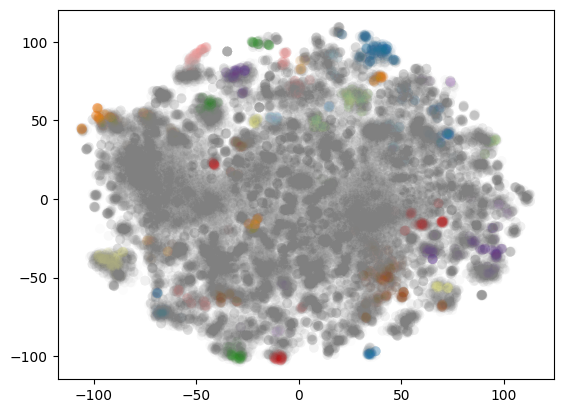

In [93]:
color_palette = sns.color_palette('Paired', max(clusterer.labels_) + 1)
cluster_colors = [color_palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*tsne_results.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.025)

In [77]:
umap_embeddings = cluster.run_umap(
    scaled_embeddings=embeddings,
    n_components=40,
    visualize=True
)

Running UMAP with n_components=40, n_neighbors=15, min_dist=None, metric=cosine


/Users/abhishek/micromamba/envs/venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.vq import kmeans
tsne = TSNE(n_components=2, random_state=42)

tsne_result_umap = tsne.fit_transform(umap_embeddings)

# Plot the results
plt.figure(figsize=(10, 8))
plt.scatter(tsne_result_umap[:, 0], tsne_result_umap[:, 1], alpha=0.025)
plt.title('t-SNE visualization of embedding vectors')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()


In [ ]:
clusterer = HDBSCAN(
    min_cluster_size=60,
    min_samples=10,
    cluster_selection_method='leaf',
    allow_single_cluster=True,
    metric='euclidean',
    cluster_selection_epsilon=0.5,
    prediction_data=True,
    memory='auto',
).fit(scaled_embeddings)



🚀 Running: n150_c15_mcs800_ms100


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


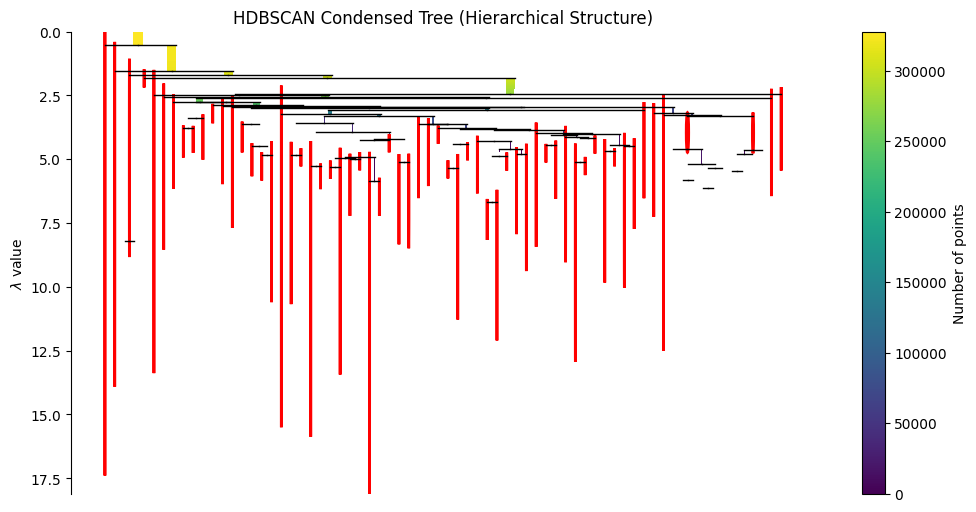

⚠️ Skipping further processing for n150_c15_mcs800_ms100 (Too many clusters: 61 or Too much noise: 0.4416553492133734)
✅ Results saved to Final_HDBSCAN_Results.xlsx

🎉 All parameter combinations processed! 🚀


In [29]:
# 🚀 Set hyperparameters to iterate over
from collections import Counter

n_neighbors_list = [150]  
n_components_list = [15]
min_cluster_size_list = [800]  # Increased range
min_samples_list = [100]  # Increased range

# 📌 Load dataset
# df = pd.read_csv("SAMPLE_EMBEDDINGS.csv")
embeddings_array = np.array(df['embeddings'].tolist())

# 📊 Standardize the embeddings
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(embeddings_array)

# 📝 Create an Excel writer
excel_filename = "Final_HDBSCAN_Results.xlsx"
writer = pd.ExcelWriter(excel_filename, engine='openpyxl')

# 🔄 Metadata storage
metadata = []

# 📌 Track best setting
best_setting = None
best_noise_ratio = 1.0  # Initialize with worst possible noise % (100%)
best_cluster_distribution_confidence = 0   # Initialize with worst possible confidence (0%)

# 🔄 Iterate over parameter combinations
for n_neighbors, n_components, min_cluster_size, min_samples in product(
    n_neighbors_list, n_components_list, min_cluster_size_list, min_samples_list
):
    run_id = f"n{n_neighbors}_c{n_components}_mcs{min_cluster_size}_ms{min_samples}"
    print(f"\n🚀 Running: {run_id}")
    start_time = time.time()

    # 🌀 Step 1: UMAP Reduction
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        n_components=n_components,
        metric='euclidean',
        n_jobs=-1,
        low_memory=True
    )
    reduced_embeddings = reducer.fit_transform(scaled_embeddings)

    # 🔍 Step 2: HDBSCAN Clustering
    clusterer = HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        metric='euclidean',
        cluster_selection_method='eom',
        prediction_data=True
    )
    cluster_labels = clusterer.fit_predict(reduced_embeddings)

    # 📌 Visualize the hierarchy
    plt.figure(figsize=(12, 6))
    clusterer.condensed_tree_.plot(select_clusters=True, cmap='viridis')
    plt.title("HDBSCAN Condensed Tree (Hierarchical Structure)")
    plt.show()

    n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    n_noise = (cluster_labels == -1).sum()
    noise_ratio = n_noise / len(cluster_labels)  # Percentage of noise points

    # 🔥 **Skip processing if clusters > 35 or noise_ratio > 30**
    if n_clusters > 60 or noise_ratio > 50:
        print(f"⚠️ Skipping further processing for {run_id} (Too many clusters: {n_clusters} or Too much noise: {noise_ratio})")
        continue  # Moves to the next parameter set

    df['cluster'] = cluster_labels
    df['cluster_probability'] = clusterer.probabilities_

    # 📊 Step 3: Compute clustering statistics
    cluster_distribution = df['cluster'].value_counts(normalize=True) * 100
    cluster_distribution = cluster_distribution[cluster_distribution.index != -1]  # Exclude noise points
    ## We don't want the top class to overshadow all the other classes, a somewhat distributed clustering is preferred
    cluster_distribution_confidence = 1 - (cluster_distribution.std() / cluster_distribution.mean())

    print(f"📊 Clusters found: {n_clusters}")
    print(f"🔴 Noise points: {n_noise} ({noise_ratio:.2%})")
    print(f"📊 Cluster sizes: {cluster_distribution.round(2).astype(str) + '%'}")
    print(f"📊 Cluster distribution confidence: {cluster_distribution_confidence:.2%}")
    print(f"⏰ Time taken: {time.time() - start_time:.2f} seconds")

    # 📌 Store metadata
    metadata.append([run_id, n_neighbors, n_components, min_cluster_size, min_samples, n_clusters, n_noise])

    # 🔥 Update best setting if noise ratio is lower
    if noise_ratio < best_noise_ratio and cluster_distribution_confidence > best_cluster_distribution_confidence and n_clusters > 5 and n_clusters < 50:  # Ensuring we don't get too few clusters or too many clusters
        best_setting = (n_neighbors, n_components, min_cluster_size, min_samples)
        best_noise_ratio = noise_ratio
        best_cluster_distribution_confidence = cluster_distribution_confidence

    # 💾 Save clustering results as a new Excel sheet
    df[['templatehash', 'cleaned_transactionnote', 'cleaned_pos', 'cluster', 'cluster_probability']].to_excel(writer, sheet_name=run_id, index=False)

# 🔹 Step 4: Save metadata sheet
metadata_df = pd.DataFrame(metadata, columns=[
    "Run_ID", "n_neighbors", "n_components", "min_cluster_size", "min_samples",
    "Num_Clusters", "Noise_Points"
])
metadata_df.to_excel(writer, sheet_name="Metadata", index=False)

# 🔹 Save the final Excel file
writer.close()
print(f"✅ Results saved to {excel_filename}")

# 🔥 Step 5: Generate WordClouds for Best Configuration
if best_setting:
    best_n_neighbors, best_n_components, best_min_cluster_size, best_min_samples = best_setting
    print(
        f"\n🚀 Best Setting: n_neighbors={best_n_neighbors}, n_components={best_n_components}, "
        f"min_cluster_size={best_min_cluster_size}, min_samples={best_min_samples}"
    )

    # Reload best configuration
    best_run_id = f"n{best_n_neighbors}_c{best_n_components}_mcs{best_min_cluster_size}_ms{best_min_samples}"
    df_best = pd.read_excel(excel_filename, sheet_name=best_run_id)

    # 🎨 Define WordCloud function
    def plot_wordcloud(cluster_id):
        print(f"🎨 Generating word cloud for Cluster {cluster_id}...")

        text = " ".join(df_best[df_best["cluster"] == cluster_id]["cleaned_pos"].astype(str))

        if len(text) == 0:
            print(f"⚠️ Skipping Cluster {cluster_id} (empty)")
            return

        wordcloud = WordCloud(width=400, height=400, background_color="white", colormap="viridis").generate(text)

        # 📌 Extract top 10 words
        words = text.split()
        word_counts = Counter(words)
        top_10_words = word_counts.most_common(10)

        # Print Top 10 Words
        print(f"🔝 Top 10 Words in Cluster {cluster_id}:")
        for word, count in top_10_words:
            print(f"{word}: {count}")

        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"WordCloud for Cluster {cluster_id}", fontsize=14)
        plt.show()

    # 🔍 Generate WordClouds for selected clusters
    for cluster in df_best["cluster"].value_counts().index[:5]:  # Top 5 clusters
        if cluster != -1:
            plot_wordcloud(cluster)

print("\n🎉 All parameter combinations processed! 🚀")


0                                     rail recipe
1               groww invest tech private limited
2          nextbillion technology private limited
3                                      rupeeredee
4              sayyam investments private limited
                            ...                  
3103199                        google lin yongbin
3103208                     beeline ge tbilisi ge
3103210          p e cisana murjikneli tbilisi ge
3103211           tashir pizza georgia tbilisi ge
3103221                                 c p tieza
Name: cleaned_pos, Length: 327665, dtype: object


🚀 Running: n10_c2_k10


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


✅ UMAP done! Shape: (315492, 2)
📊 Silhouette Score: 0.3753


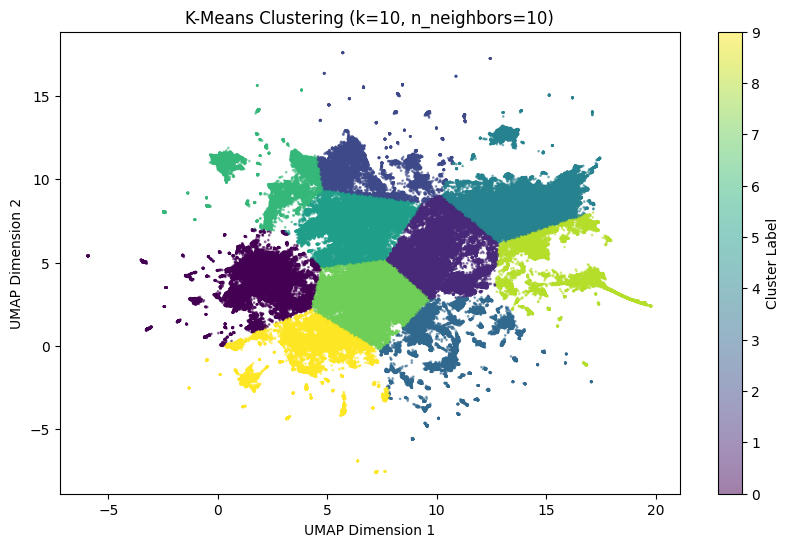


🚀 Running: n10_c2_k20
✅ UMAP done! Shape: (315492, 2)
📊 Silhouette Score: 0.3726


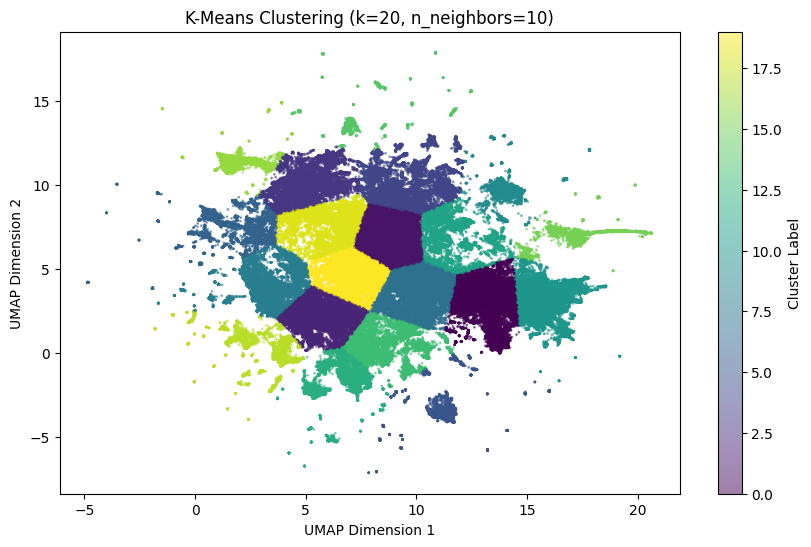


🚀 Running: n10_c2_k30
✅ UMAP done! Shape: (315492, 2)
📊 Silhouette Score: 0.3809


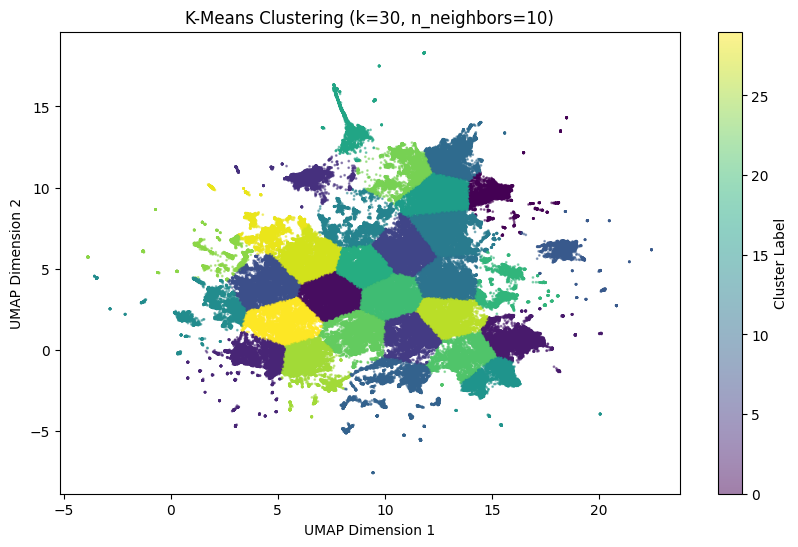


🚀 Running: n10_c2_k40
✅ UMAP done! Shape: (315492, 2)
📊 Silhouette Score: 0.3914


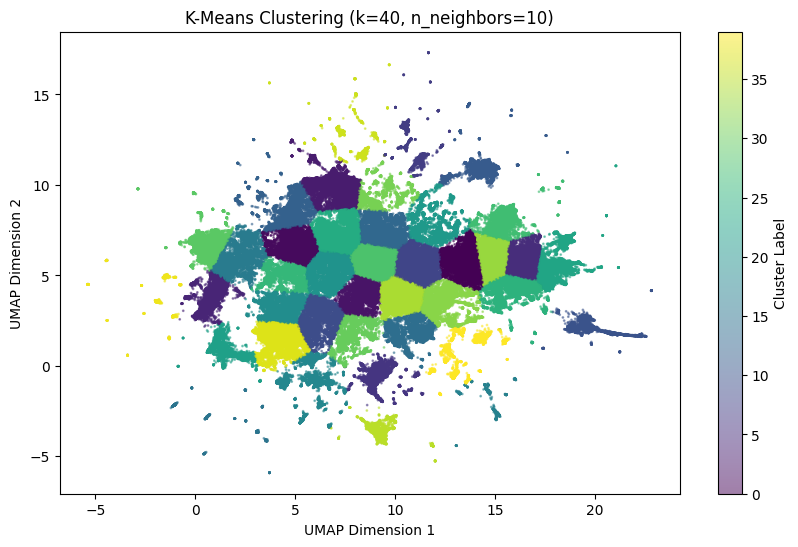


🚀 Running: n10_c2_k50
✅ UMAP done! Shape: (315492, 2)
📊 Silhouette Score: 0.3938


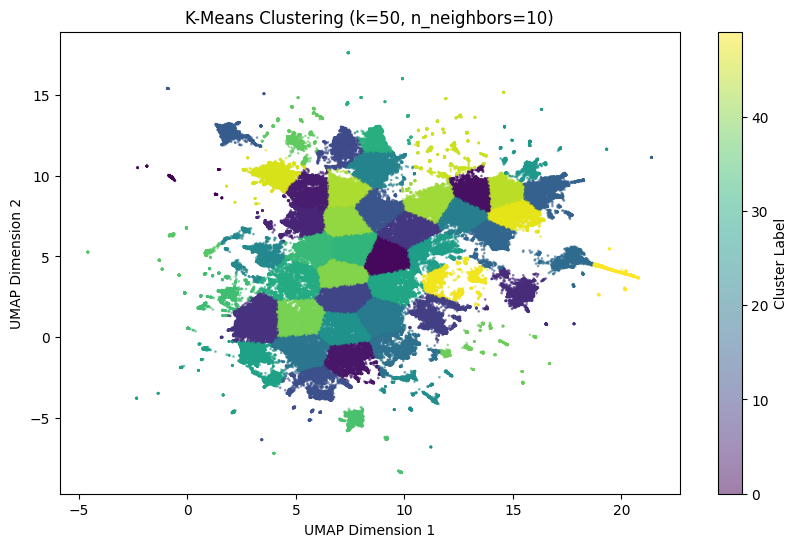


🚀 Running: n10_c5_k10
✅ UMAP done! Shape: (315492, 5)
📊 Silhouette Score: 0.3592


In [ ]:
embeddings_array = np.array(df['embeddings'].tolist())

# 📊 Standardize the embeddings
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(embeddings_array)

# 🔄 Hyperparameters for testing
n_neighbors_list = [10, 30]      # Controls UMAP neighborhood size
n_components_list = [2, 5, 10]   # Controls UMAP dimensions (for visualization)
k_values = [10, 20, 30, 40, 50]  # Number of clusters to try

# 💾 Save results to Excel
excel_filename = "Final_KMeans_Results.xlsx"
writer = pd.ExcelWriter(excel_filename, engine='openpyxl')

# 🔄 Iterate over parameter combinations
metadata = []
best_k = None
best_silhouette = -1

for n_neighbors, n_components, k in product(n_neighbors_list, n_components_list, k_values):
    run_id = f"n{n_neighbors}_c{n_components}_k{k}"
    print(f"\n🚀 Running: {run_id}")

    # 🌀 Step 1: UMAP Reduction
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        n_components=n_components,
        metric='euclidean',
        n_jobs=-1,
        low_memory=True
    )
    reduced_embeddings = reducer.fit_transform(scaled_embeddings)

    print(f"✅ UMAP done! Shape: {reduced_embeddings.shape}")

    # 🔍 Step 2: K-Means Clustering
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(reduced_embeddings)
    df['cluster'] = cluster_labels

    # 📊 Step 3: Compute clustering statistics
    silhouette_avg = silhouette_score(reduced_embeddings, cluster_labels)
    print(f"📊 Silhouette Score: {silhouette_avg:.4f}")

    # 🔥 Track best setting
    if silhouette_avg > best_silhouette:
        best_silhouette = silhouette_avg
        best_k = k

    # 📌 Store metadata
    metadata.append([run_id, n_neighbors, n_components, k, silhouette_avg])

    # 💾 Save clustering results
    df.to_excel(writer, sheet_name=run_id, index=False)

    # 🎨 Step 4: Visualization (Only for 2D UMAP Runs)
    if n_components == 2:
        plt.figure(figsize=(10, 6))
        scatter = plt.scatter(
            reduced_embeddings[:, 0], reduced_embeddings[:, 1], 
            c=cluster_labels, cmap="viridis", s=1, alpha=0.5
        )
        plt.colorbar(scatter, label="Cluster Label")
        plt.title(f"K-Means Clustering (k={k}, n_neighbors={n_neighbors})")
        plt.xlabel("UMAP Dimension 1")
        plt.ylabel("UMAP Dimension 2")
        plt.show()

# 🔹 Step 5: Save metadata
metadata_df = pd.DataFrame(metadata, columns=["Run_ID", "n_neighbors", "n_components", "k", "Silhouette_Score"])
metadata_df.to_excel(writer, sheet_name="Metadata", index=False)
writer.close()

print(f"✅ Results saved to {excel_filename}")
print(f"🔥 Best K: {best_k} with Silhouette Score: {best_silhouette:.4f}")

# 🎨 Step 6: Plot Silhouette Score vs K
plt.figure(figsize=(8, 6))
sns.lineplot(x=[x[3] for x in metadata], y=[x[4] for x in metadata], marker="o")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs K")
plt.grid()
plt.show()

# 🔍 Generate WordClouds for selected clusters
for cluster in df_best["cluster"].value_counts().index[:5]:  # Top 5 clusters
    if cluster != -1:
        plot_wordcloud(cluster)



In [27]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# 🔹 Step 1: Reduce Dimensions with UMAP (Optional but Recommended)
print("🌀 Reducing dimensions using UMAP...")
reducer = umap.UMAP(n_components=15, random_state=42)
reduced_embeddings = reducer.fit_transform(embeddings_array)
print(f"✅ Dimensionality reduced! Shape: {reduced_embeddings.shape}")

# 🔹 Step 2: Apply K-Means Clustering
print("🔍 Running K-Means...")
num_clusters = 50  # Adjust as needed
kmeans = KMeans(n_clusters=num_clusters, n_init='auto', random_state=42)
df["cluster"] = kmeans.fit_predict(reduced_embeddings)
print("✅ K-Means clustering completed!")

# 🔹 Step 3: Assign Cluster Centers
df["cluster_center"] = df["cluster"].parallel_apply(lambda x: kmeans.cluster_centers_[x])

# 🔹 Step 4: Visualize Clusters in 2D
print("🎨 Visualizing clusters with UMAP projection...")
reducer_2d = umap.UMAP(n_components=2, random_state=42)
embeddings_2d = reducer_2d.fit_transform(reduced_embeddings)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=df["cluster"], cmap="viridis", s=1, alpha=0.5)
plt.colorbar(scatter, label="Cluster Label")
plt.title("K-Means Clustering of Merchant Embeddings")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()

# 🔹 Step 5: Print Cluster Insights
print("\n📊 Cluster Summary:")
print(df["cluster"].value_counts())

print("\n🔹 Sample from each cluster:")
for cluster in sorted(df["cluster"].unique()):
    print(f"\nCluster {cluster}:")
    print(df[df["cluster"] == cluster].head(3))  # Adjust for more samples


🌀 Reducing dimensions using UMAP...


/Users/abhishek/micromamba/envs/dai/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


: 